## Data set

In [1]:
import matplotlib.pyplot as plt # 시각화를 위한 라이브러리

import torch # PyTorch 라이브러리
import torch.nn as nn # 모델 구성을 위한 라이브러리
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader # optimizer 설정을 위한 라이브러리

import torchvision # PyTorch의 컴퓨터 비전 라이브러리
import torchvision.transforms as T # 이미지 변환을 위한 모듈
import torchvision.utils as vutils # 이미지를 쉽게 처리하기 위한 유틸리티 모듈

import random

In [2]:
 # seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [36]:
transform_train = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_valid = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                          
])

In [37]:
root = './data'
training_dataset = torchvision.datasets.CIFAR10(root=root, train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root=root, train=False, transform=transform_valid, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [38]:
num_train, num_val = int(len(training_dataset) * 0.8), int(len(training_dataset) * 0.2)
train_dataset, valid_dataset = torch.utils.data.random_split(training_dataset, [num_train, num_val])
print(len(train_dataset))
print(len(valid_dataset))

40000
10000


In [39]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
images, labels = next(iter(train_dataloader))

print(images.shape) 

torch.Size([32, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


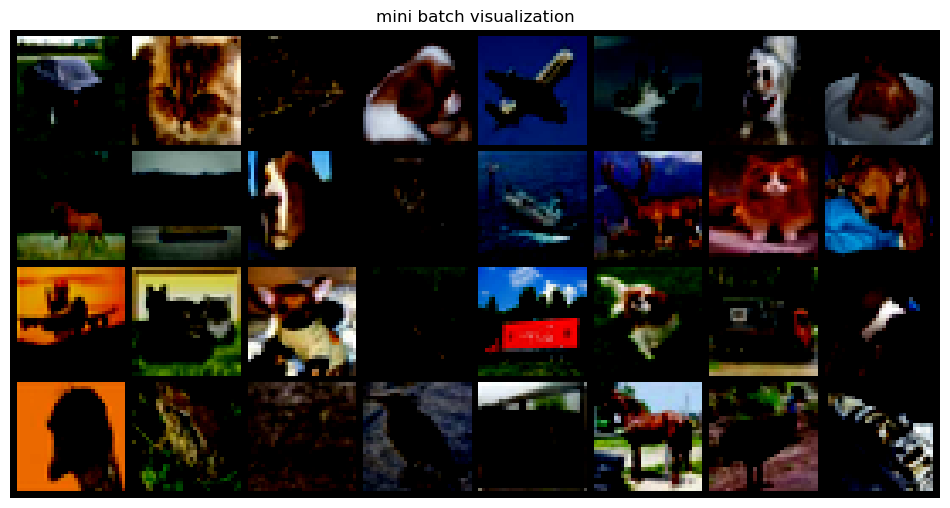

In [41]:
grid = vutils.make_grid(images, nrow=8) # 미니배치로 불러온 이미지를 하나의 그리드로 만들어 시각화

plt.figure(figsize=(12,12))
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.title("mini batch visualization")
plt.axis('off')
plt.show()

## Pytorch lighting

In [16]:
import torch
import torch.nn as nn
from pytorch_lightning import LightningModule, Trainer, LightningDataModule

from torchmetrics import Accuracy 

In [12]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger

In [42]:
class Classifier(LightningModule):
    def __init__(self, num_classes, dropout_ratio, lr=0.001):
        super().__init__()
        self.learning_rate = lr
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()
        
         
        self.num_classes = num_classes
        self.dropout_ratio = dropout_ratio
        
        self.layer = nn.Sequential(
            # 입력: (32, 3, 32, 32)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # (32, 32, 32, 32)
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # (32, 64, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 64, 16, 16)
            nn.Dropout(self.dropout_ratio),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # (32, 128, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 128, 8, 8)
            nn.Dropout(self.dropout_ratio),
        )
        
        self.fc_layer1 = nn.Linear(8*8*128, 64) 
        self.fc_layer2 = nn.Linear(64, self.num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(x.size(0), -1)
        out = self.fc_layer1(out)
        pred = self.fc_layer2(out)
        
        return pred 
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        images, labels = batch 
        
        outputs = self(images)
        
        loss = self.criterion(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, logger=True) 
        return loss 
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
        acc = self.accuracy(preds, labels)
        
        self.log(f"valid_loss", loss, on_step=False, on_epoch=True, logger=True)
        self.log(f"valid_acc", acc ,on_step=False, on_epoch=True, logger=True) 
    
    def test_step(self, batch, batch_idx):
        images, labels = batch 
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
        acc = self.accuracy(preds, labels)
        
        self.log(f"test_loss", loss, on_step=False, on_epoch=True)
        self.log(f"test_acc", acc, on_step=False, on_epoch=True)
        
    def predict_step(self, batch, batch_idx):
        images, labels = batch 
        outputs = self(images)
        _, preds = torch.max(outputs, dim=1)

        return preds     

In [43]:
model = Classifier(num_classes=10, dropout_ratio=0.2)

early_stopping = EarlyStopping(monitor='valid_loss', mode= 'min')
csv_logger = CSVLogger(save_dir= "./csv_logger", name='test')

trainer = Trainer(
    max_epochs=30,
    accelerator='auto',
    callbacks= [early_stopping],
    logger= csv_logger
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [44]:
trainer.fit(model, train_dataloader, valid_dataloader)


  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | accuracy  | MulticlassAccuracy | 0      | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | layer     | Sequential         | 93.2 K | train
3 | fc_layer1 | Linear             | 524 K  | train
4 | fc_layer2 | Linear             | 650    | train
5 | softmax   | LogSoftmax         | 0      | train
---------------------------------------------------------
618 K     Trainable params
0         Non-trainable params
618 K     Total params
2.473     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [45]:
trainer.test(model, test_dataloader)

/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7559000253677368     │
│         test_loss         │    0.7160964012145996     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7160964012145996, 'test_acc': 0.7559000253677368}]